<a href="https://colab.research.google.com/github/sobhaniiest/Major-Project-source-camera-identification-/blob/master/FBL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0
Running on TPU  ['10.21.41.122:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.21.41.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.21.41.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import numpy as np
import os
import time
from resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout,Activation,Flatten

from imagenet_utils import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [15]:
Img_size = 512
epochs = 20
batch_size = 64

# Loading the training data
# Define data path
data_path = '/content/drive/My Drive/FBL'
data_dir_list = os.listdir(data_path)

img_data_list=[]


for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		img_path = data_path + '/'+ dataset + '/'+ img 
		img = image.load_img(img_path, target_size=(Img_size, Img_size))
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		x = preprocess_input(x)
		print('Input image shape:', x.shape)
		img_data_list.append(x)

img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)


# Define the number of classes
num_classes = 5
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:150]=0
labels[150:300]=1
labels[300:450]=2
labels[450:600]=3
labels[600:]=4


# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

Loaded the images of dataset-05

Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512, 3)
Input image shape: (1, 512, 512

In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:

# Custom_resnet_model_1
#Training the classifier alone
image_input = Input(shape=(Img_size, Img_size, 3))

model = ResNet50(input_tensor=image_input, require_flatten=False,weights='imagenet')
model.summary()
last_layer = model.get_layer('avg_pool').output
x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output_layer')(x)
custom_resnet_model = Model(inputs=image_input,outputs= out)
custom_resnet_model.summary()

for layer in custom_resnet_model.layers[:-1]:
	layer.trainable = False

custom_resnet_model.layers[-1].trainable

custom_resnet_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy', f1_m, precision_m, recall_m])

t=time.time()
hist = custom_resnet_model.fit(X_train, y_train, batch_size, epochs, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy, f1_score, precision, recall) = custom_resnet_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%, F1-score={:.4f}, Precision={:.4f}, Recall={:.4f}".format(loss, accuracy * 100, f1_score, precision, recall))


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 518, 518, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = custom_resnet_model.predict(X_test)
print("Class")
print(y_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Confusion Matrix')
print(matrix)

Class
[[0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0.

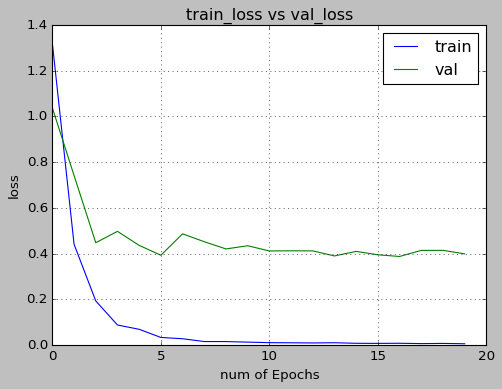

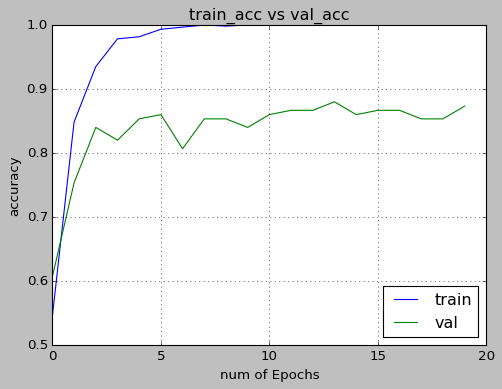

In [19]:
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [20]:
# Fine tune the resnet 50

image_input = Input(shape=(Img_size, Img_size, 3))
model = ResNet50(input_tensor=image_input, weights='imagenet', require_flatten=False)
model.summary()
last_layer = model.output
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(last_layer)

# add fully-connected & dropout layers
x = Dense(512, activation='relu',name='fc-1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',name='fc-2')(x)
x = Dropout(0.5)(x)

###
#x = Dense(128, activation='relu',name='fc-3')(x)
#x = Dropout(0.5)(x)
###
# a softmax layer for 5 classes
out = Dense(num_classes, activation='softmax',name='output_layer')(x)

# this is the model we will train
custom_resnet_model2 = Model(inputs=model.input, outputs=out)

custom_resnet_model2.summary()

for layer in custom_resnet_model2.layers[:-6]:
	layer.trainable = False

custom_resnet_model2.layers[-1].trainable

custom_resnet_model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy', f1_m, precision_m, recall_m])

t=time.time()
hist = custom_resnet_model2.fit(X_train, y_train, batch_size, epochs, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy, f1_score, precision, recall) = custom_resnet_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%, F1-score={:.4f}, Precision={:.4f}, Recall={:.4f}".format(loss, accuracy * 100, f1_score, precision, recall))

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 518, 518, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = custom_resnet_model2.predict(X_test)
print("Class")
print(y_test)
print("Pred")
for li in y_pred:
	m = 0
	i = 0
	for v in li:
		i += 1
		if v > m:
			m = v
			index = i
	out = []
	for v in li:
		if v != m:
			out.append(0)
		else:
			out.append(1)
	print(out)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Confusion Matrix')
print(matrix)

Class
[[0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0.

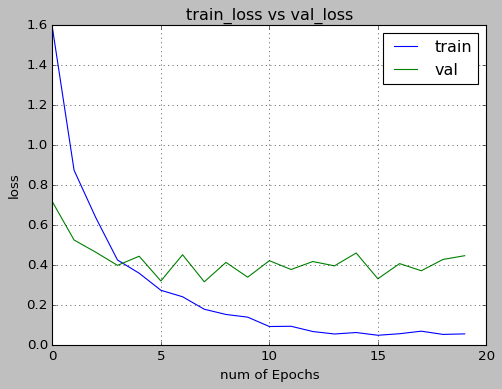

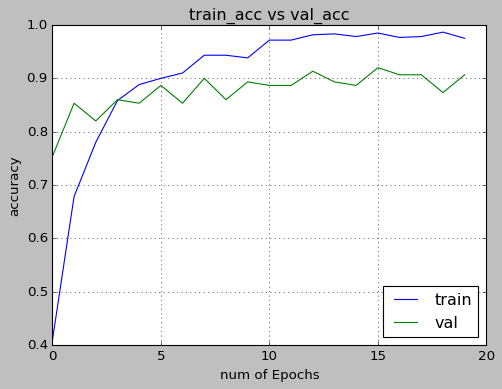

In [24]:
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])